# Importing Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [26]:
# Configure API key 

quandl.ApiConfig.api_key = 'QEbHh1gaq3BaDt-sTCD7'

# 6.6.2 Find a data set to work and import it into your Jupyter notebook. 
# Import Data for US Federal Reserve Data Releases

In [30]:
data = quandl.get('FED/SUBLPDMHS_XWB_N_Q')

In [31]:
data.head(5)

,Value
Date,
2018-03-31,10.0
2018-06-30,5.3
2018-09-30,-13.3
2018-12-31,-12.0
2019-03-31,-1.7


In [32]:
data.shape

(22, 1)

In [33]:
data.columns

Index(['Value'], dtype='object')

In [34]:
type(data)

pandas.core.frame.DataFrame

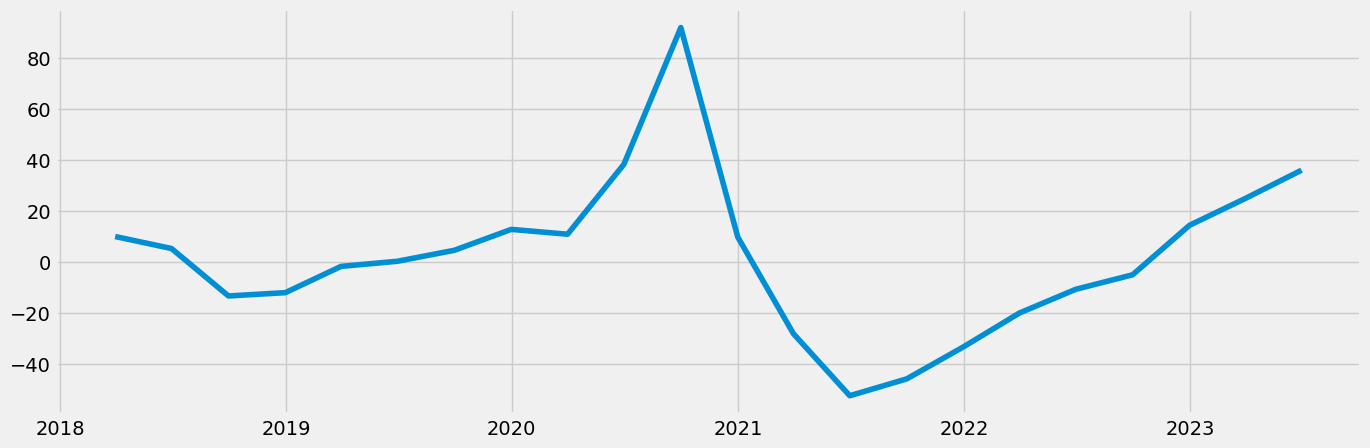

In [35]:
# Plot the data with matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

#  6.6.3 Make a subset of your data set if necessary.

In [36]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [37]:
data_2.head()

,Date,Value
0,2018-03-31,10.0
1,2018-06-30,5.3
2,2018-09-30,-13.3
3,2018-12-31,-12.0
4,2019-03-31,-1.7


In [46]:
data_sub = data_2.loc[(data_2['Date'] >= '2019-12-31') & (data_2['Date'] < '2023-06-30')]

# In a markdown cell below the subset (if you make one), explain what logic you were following when selecting your data points.
#I chose the date range above becuase this is the date range that was used an example for "when filtering by date range." 

In [47]:
data_sub.shape

(14, 2)

In [48]:
data_sub.head()

,Date,Value
7,2019-12-31,12.8
8,2020-03-31,10.9
9,2020-06-30,38.3
10,2020-09-30,91.9
11,2020-12-31,9.8


In [49]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2019-12-31,12.8
2020-03-31,10.9
2020-06-30,38.3
2020-09-30,91.9
2020-12-31,9.8


# 6.6.4 Create a line chart of your data.

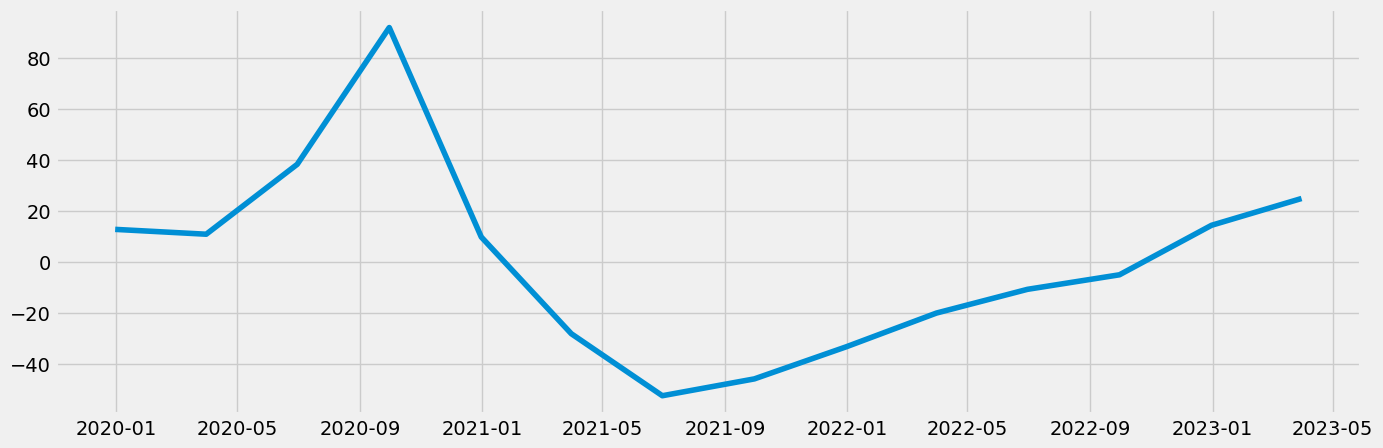

In [50]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [51]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [52]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

# 6.6.5 Decompose the data’s components.

In [53]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [54]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

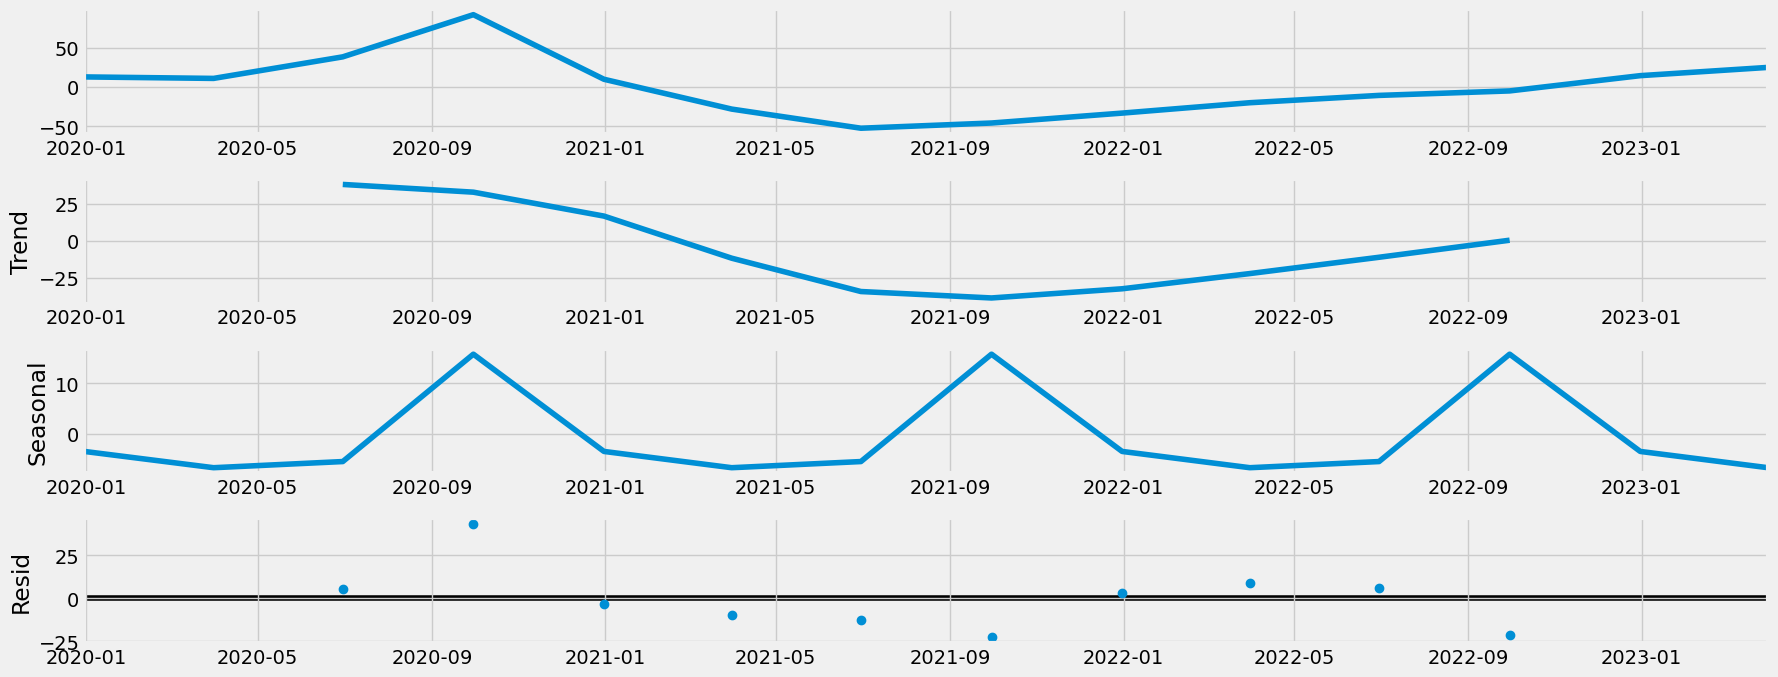

In [55]:
# Plot the separate components

decomposition.plot()
plt.show()

# Analyze the results from the plot in a markdown cell.
The Level (data itself) is showing a peak in 9/2020, followed by a steep drop and gradual rise
The Trend appears somewhat similar to the level, which might suggest the data does not need to be smoothed
The Seasonality shows a consistent peak every September
The Residual shows that there is not much noise, which might also suggest that the data does not need to be smoothed

# 6.6.6 Conduct a Dickey-Fuller test to check for stationarity.

In [56]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 3.169008
p-value                        1.000000
Number of Lags Used            5.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


# Interpret the results in a markdown cell and reference your null hypothesis.
Test Statistic is larger than the Critical Value, so I cannot reject the null hypothesis. This means there is a unit root in the data, and the data is non-stationary.

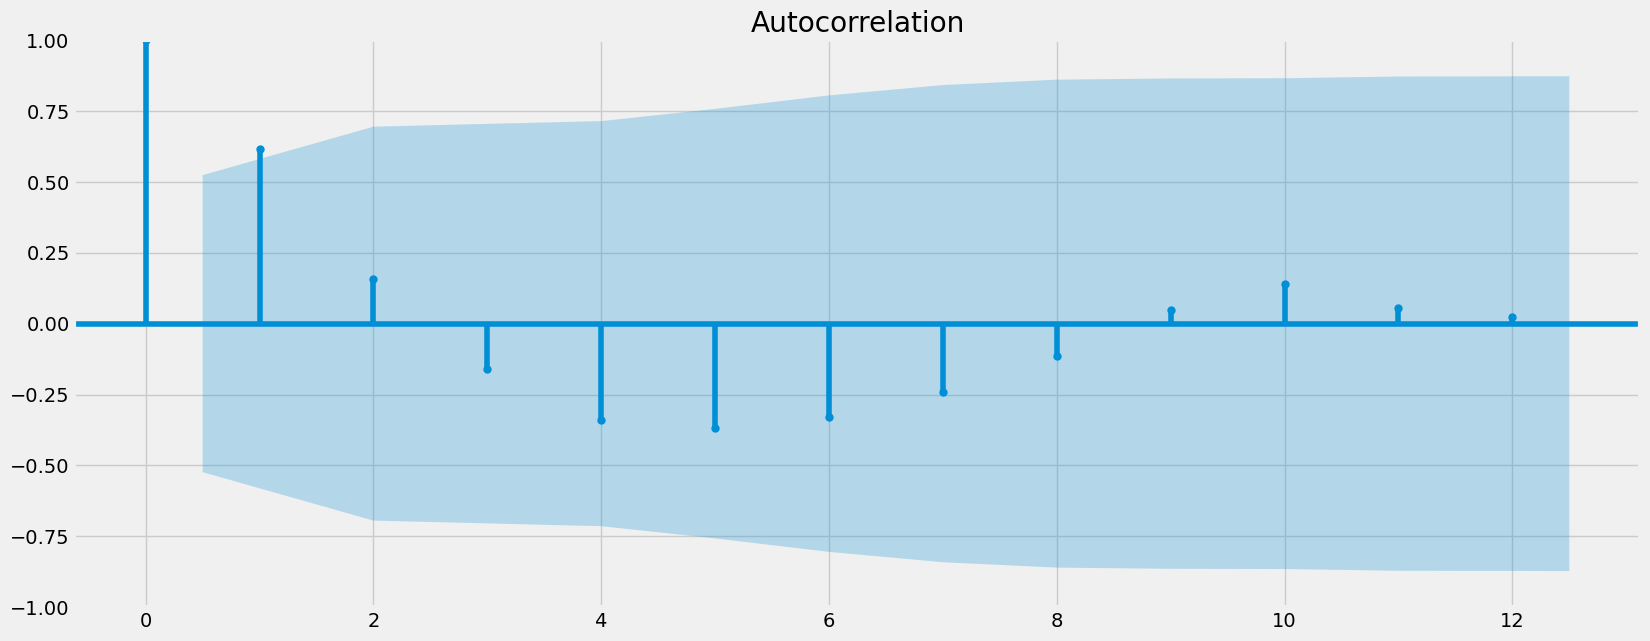

In [57]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# Stationarizing

In [58]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [59]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [60]:
data_diff.head()

,Value
datetime,
2020-03-31,-1.9
2020-06-30,27.4
2020-09-30,53.6
2020-12-31,-82.1
2021-03-31,-37.9


In [61]:
data_diff.columns

Index(['Value'], dtype='object')

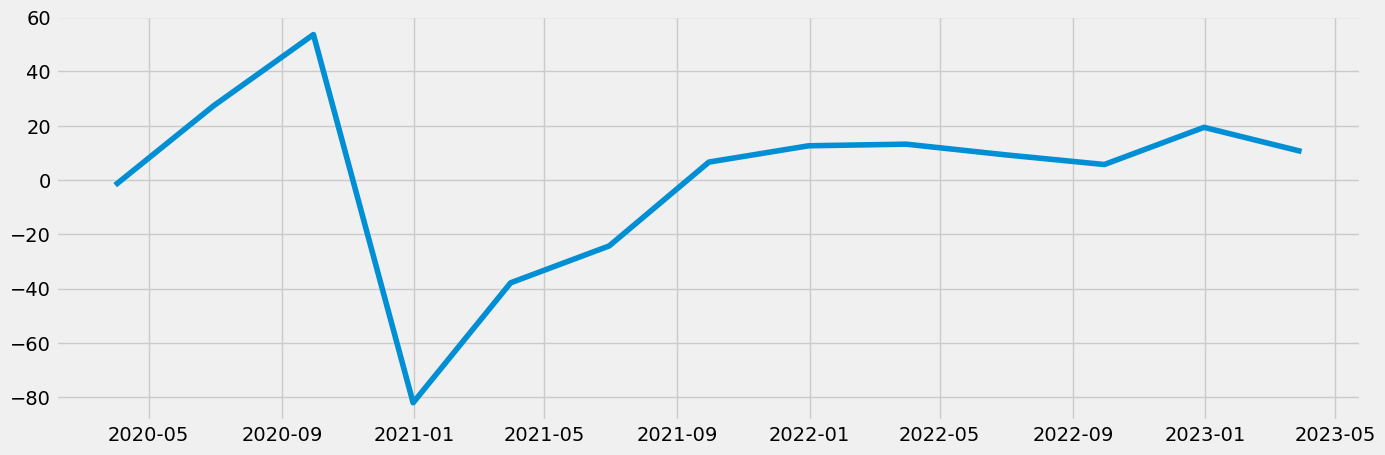

In [62]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [63]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -2.494143
p-value                         0.116906
Number of Lags Used             2.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


# Test Statistic is larger than the Critical Value, so I cannot reject the null hypothesis. This means there is a unit root in the data, and the data is non-stationary.

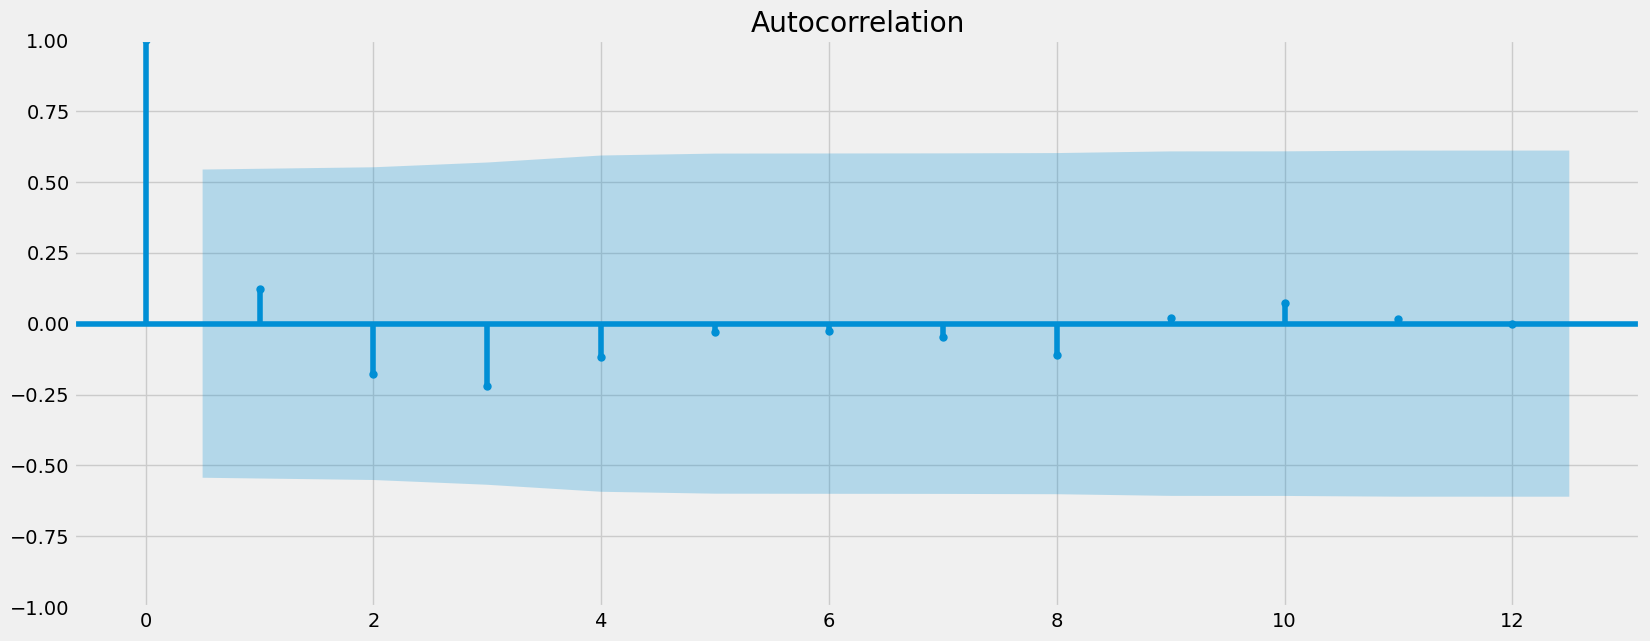

In [64]:
plot_acf(data_diff)
plt.show()

# 6.6.7 If your data isn’t stationary, conduct a round of differencing on it and repeat step 6.

In [82]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_diff['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.494143
p-value                         0.116906
Number of Lags Used             2.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


# Test Statistic is larger than the Critical Value, so I cannot reject the null hypothesis. This means there is a unit root in the data, and the data is non-stationary.

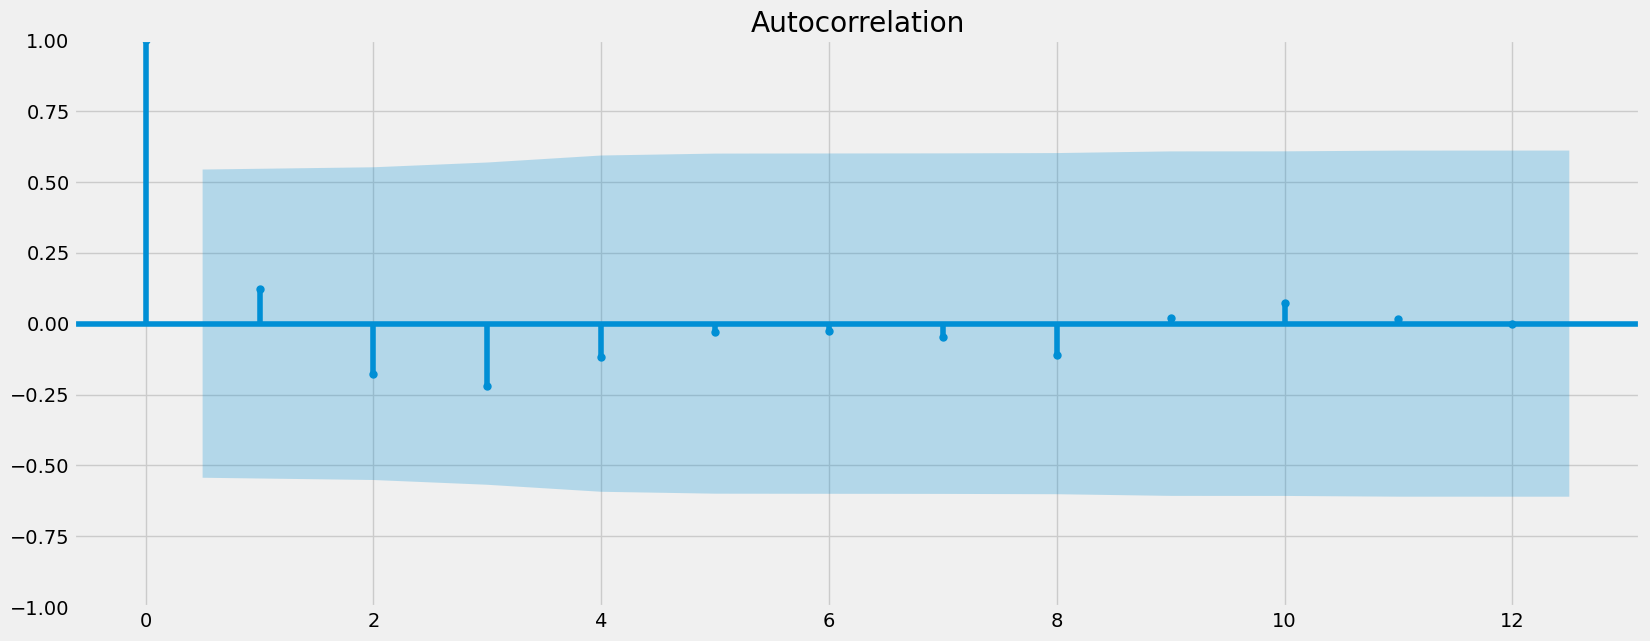

In [83]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff)
plt.show()

In [84]:
data_diff2 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [85]:
data_diff2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [86]:
data_diff2.head()

,Value
datetime,
2020-06-30,29.3
2020-09-30,26.2
2020-12-31,-135.7
2021-03-31,44.2
2021-06-30,13.6


In [87]:
data_diff2.columns

Index(['Value'], dtype='object')

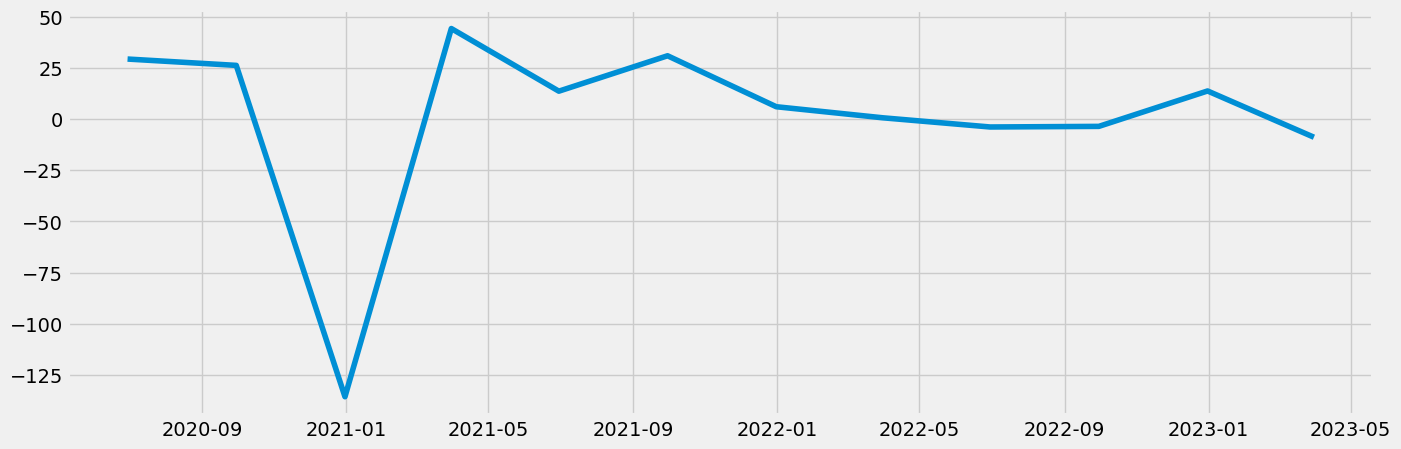

In [88]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [89]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -2.710241
p-value                        0.072283
Number of Lags Used            4.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


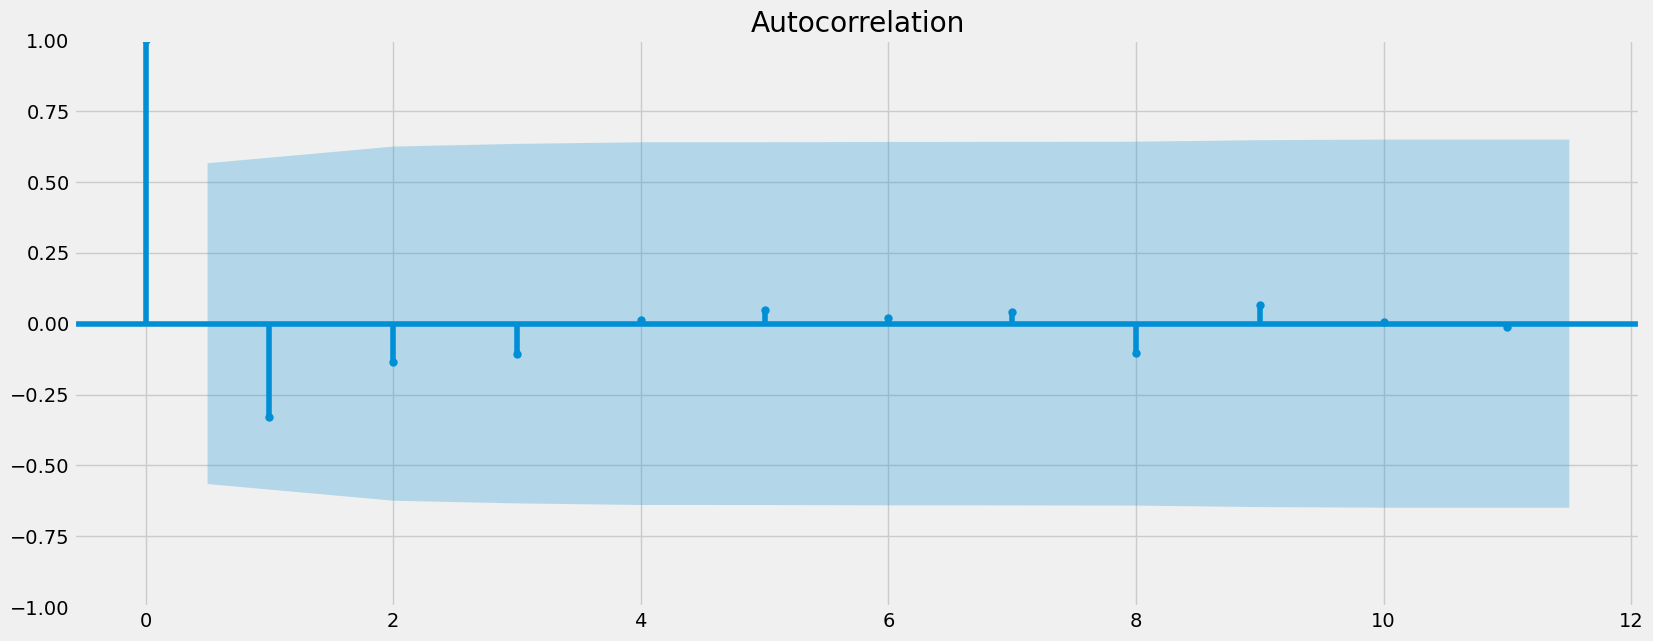

In [90]:
plot_acf(data_diff2)
plt.show()

# 6.6.8 If your data still isn’t stationary, perform another round of differencing and repeat step 6.

In [91]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_diff2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -2.710241
p-value                        0.072283
Number of Lags Used            4.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


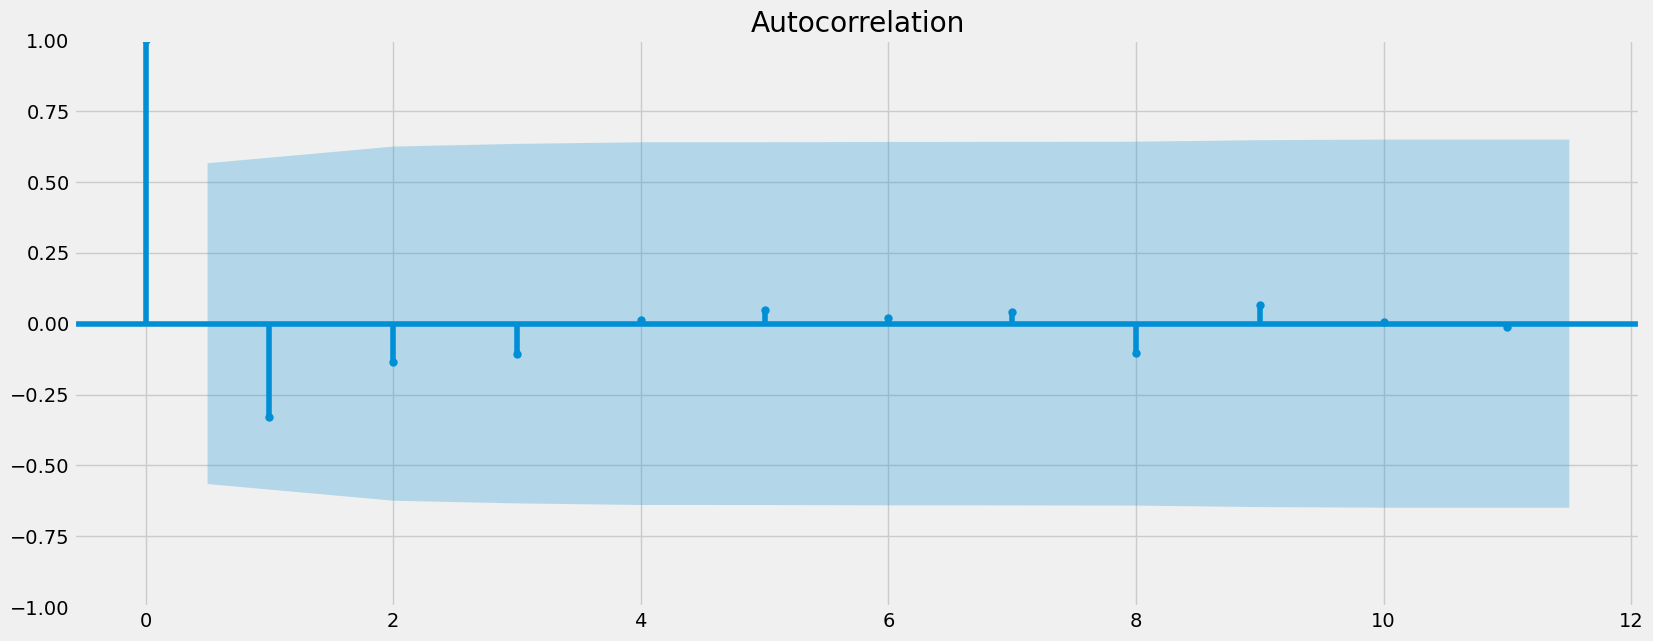

In [92]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff2)
plt.show()

In [93]:
data_diff3 = data_diff2 - data_diff2.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [94]:
data_diff3.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [95]:
data_diff3.head()

,Value
datetime,
2020-09-30,-3.1
2020-12-31,-161.9
2021-03-31,179.9
2021-06-30,-30.6
2021-09-30,17.3


In [96]:
data_diff3.columns

Index(['Value'], dtype='object')

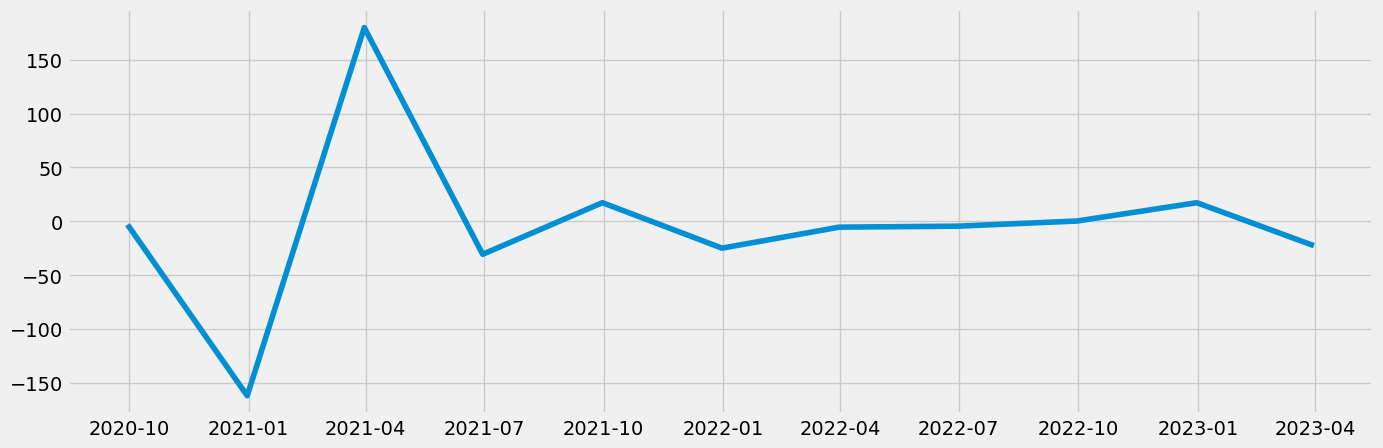

In [97]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff3)

In [98]:
dickey_fuller(data_diff3)

Dickey-Fuller Stationarity test:
Test Statistic                 -5.476072
p-value                         0.000002
Number of Lags Used             0.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


# Test Statistic is smaller than the Critical Value, so I can reject the null hypothesis. This means there is a unit root in the data, and the data is non-stationary.

# 6.6.9 Check your data’s autocorrelations.

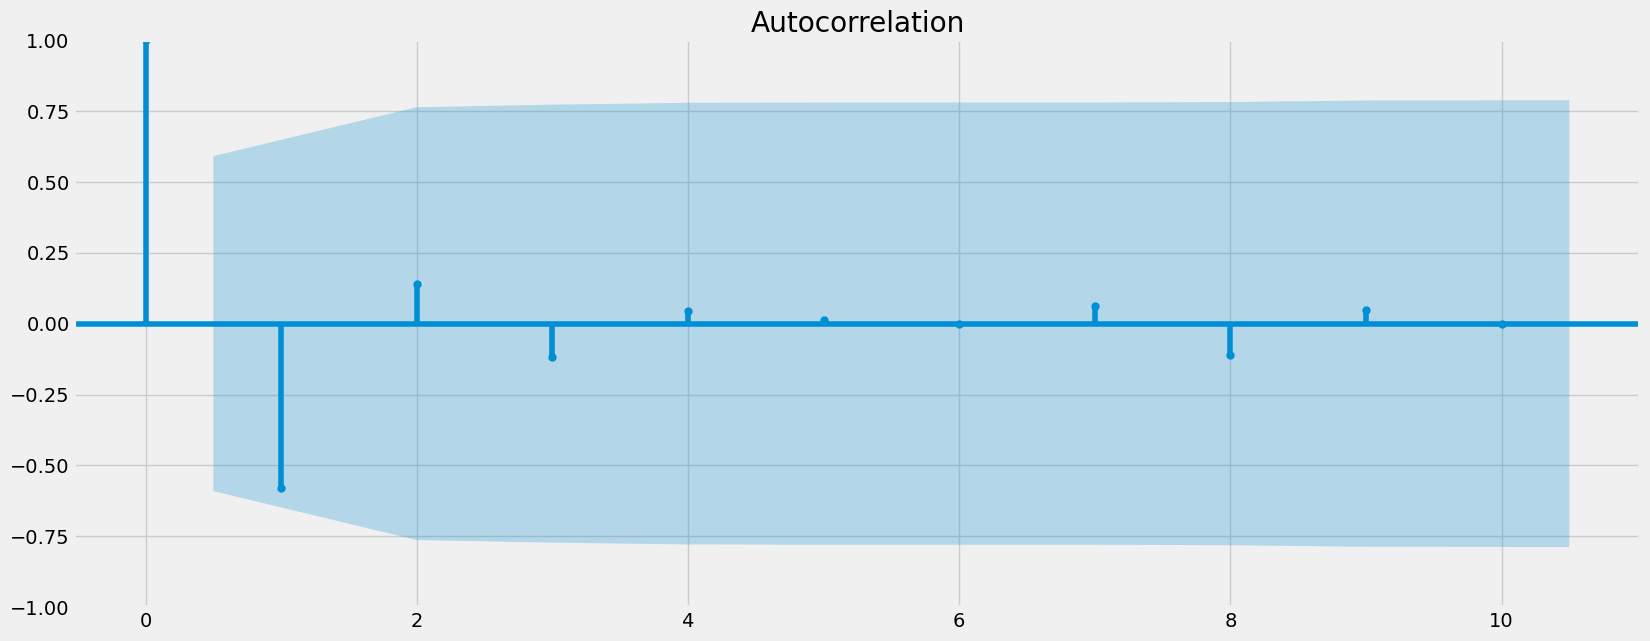

In [99]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff3)
plt.show()